In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = np.load('EURUSD_2000_to_2025.npy', allow_pickle=True) 

In [3]:
df = pd.DataFrame(data)
df = df.rename(columns={0: 'Date', 1: 'Time', 2:'Open', 3:'High', 4:'Low', 5:'Close', 6:'Seconds'})
df = df.set_index('Date')
df = df.drop('Seconds', axis = 1)
df = df.astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close':'float64'})

In [4]:
year_days = lambda year: 366 if year%4==0 else 365
ydc = lambda year: sum([year_days(y) for y in range(2000,year)])
month_days = lambda month,year: 30 if month in [4,6,9,11] else 31 if month != 2 else 28 if year%4 !=0 else 29
mdc = lambda month, year: sum([month_days(m,year) for m in range(1,month)])
hpd = 24
mph = 60
mpd = mph*hpd
t0 = (mdc(5,2000)+30)*mpd + 17*mph + 35
def to_t(date, time):
    y = int(date[:4])
    m = int(date[5:7])
    d = int(date[8:])
    h = int(time[:2])
    min = int(time[3:])
    return ((ydc(y) + mdc(m,y) + d)*mpd + mph*h + min) - t0


In [5]:
df['t'] = [to_t(idx,time) for idx,time in zip(df.index.values,df["Time"].values)]

In [16]:
new_ts = np.arange(max(df["t"])+1)
pts = np.zeros_like(new_ts, dtype=float)
mins = np.zeros_like(new_ts, dtype=float)
maxs = np.zeros_like(new_ts, dtype=float)
closes = np.zeros_like(new_ts, dtype=float)
opens = np.zeros_like(new_ts, dtype=float)
# Take average of open and close as data values for points we know
pts[df["t"]] = 0.5*(df["Open"] + df["Close"])
closes[df["t"]] = df["Close"]
opens[df["t"]] = df["Open"]
mins[df["t"]] = df["Low"]
maxs[df["t"]] = df["High"]
# One high outlier gets called a missing point
big_num = np.argmax(pts)
pts[big_num] = 0
opens[big_num] = 0
closes[big_num] = 0
mins[big_num] = 0
maxs[big_num] = 0
# All missing points and the few low outliers
idxs = new_ts[pts <= 0.5]

# Fix bad indexes to linearly connect good points around them.
for i in range(len(idxs)):
    if idxs[i-1] == idxs[i] - 1:
        continue
    idx = idxs[i]
    curr_idx = idx
    n = 1
    # Determine how many in a row there are that need to be filed
    while i+n < len(idxs) and idxs[i+n] == curr_idx+1:
        n += 1
        curr_idx += 1
    # Fill in indexes here.    
    for k in range(n):
        # pts gets linear fit from last flose to next open
        pts[idx+k] = (closes[idx-1]*(n-k) + opens[idx+n]*(k+1))/(n+1)
        # mins takes min of last min and next min
        mins[idx+k] = min(mins[idx-1], mins[idx+n])
        # maxs takes max of last max and next max
        maxs[idx+k] = max(maxs[idx-1], maxs[idx+n])


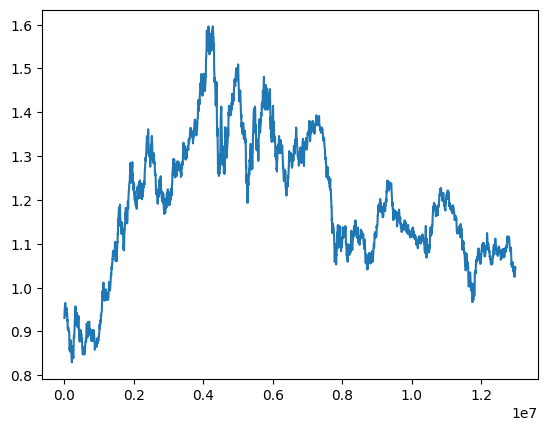

In [26]:
# Show our dataset with correct time scaling
step=5000
plt.plot(new_ts[::step], pts[::step])
plt.show()

In [33]:
# Save all data
np.save("ts.npy", new_ts)
np.save("avgs.npy", pts)
np.save("mins.npy", mins)
np.save("maxs.npy", maxs)